In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import optimize
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa import stattools
from statsmodels.tsa.statespace import tools 
from statsmodels.tsa.arima_process import ArmaProcess

In [2]:
def plot_series(X, X_=None, title='Time Series Plot', y_label='Value of X', 
                figsize=(16, 5), forecast=False, season=12):
    
    """ Plots the time series data X.

    Args:
        X (np.array): Time-series data
        X_ (np.array): Forecasted time-series data
        title (str) - Title for the figure
        y_label (str) - y-label for the figure
        figsize (tuple): Size of figure
        forecast (bool): if true appends predictions after observed data
        season (int): season

    """

    fig = plt.figure(figsize=figsize)
    
    plt.plot(X, linewidth=3)

    if X_ is not None:
        if not forecast:
            plt.plot(X_, linewidth=3)
        else:
            plt.plot(range(len(X), len(X_) + len(X)), X_)

    plt.title(title, fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    plt.xticks(
        range(0, len(X) + 1 if not forecast else len(X) + len(X_) + 1, season), 
        fontsize=14
    ) 
    
    if X_ is not None:
        plt.legend(['True Values', 'Forecasted Values'], fontsize=14)
    plt.grid()
    plt.show()


def plot_graphs(X=None, lags=121, season=12, figsize=(10, 5)):
    """ Plots ACF and PACF graphs
        
    Args:
        X (np.array): Time-series data
        lags (int): number of lags up to which ACF and PACF plots will be shown
        season (int): season  
        figsize (tuple): size for the figure
    
    """
    
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.5)

    title = 'Autocorrelation Plot'
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(X, title=title, ax=ax1, lags=lags)
    plt.title(title, fontsize=14)
    plt.xticks(range(0, lags, season), fontsize=14)
    plt.grid()

    title = 'Partial Autocorrelation Plot'  
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(X, title=title,  ax=ax2, lags=lags, method='ywmle',)
    plt.title(title, fontsize=14)
    plt.xticks(range(0, lags + 1, season), fontsize=14)
    plt.grid()
    plt.show()

In [3]:
def generate_samples(ar_params, ma_params, n_samples=10000):
    # generates samples for ARMA model based on given parameters
    ar = np.r_[1, -ar_params] 
    ma = np.r_[1, ma_params] 

    np.random.seed(999)
    X = ArmaProcess(ar, ma).generate_sample(nsample=n_samples + 2000)[2000:]  
    return X 

def generate_samples_101_101_12(phi, Phi, theta, Theta):
    """ 
    generates samples for ARIMA(1, 0, 1) x (1, 0, 1)12 model based 
    on parameters
    """
    ar_params = np.hstack([[phi], np.zeros(10), [Phi], [-Phi * phi]]) 
    ma_params = np.hstack([[theta], np.zeros(10), [Theta], [Theta * theta]]) 
    X = generate_samples(ar_params, ma_params)
    return X

def plot_graphs_101_101_12(phi, Phi, theta, Theta):
    """
    generates PACF and ACF plots ARIMA(1, 0, 1) x (1, 0, 1)12 model 
    based on parameters
    """
    X = generate_samples_101_101_12(phi, Phi, theta, Theta)
    plot_graphs(X, lags=60) # figsize=(16, 5))

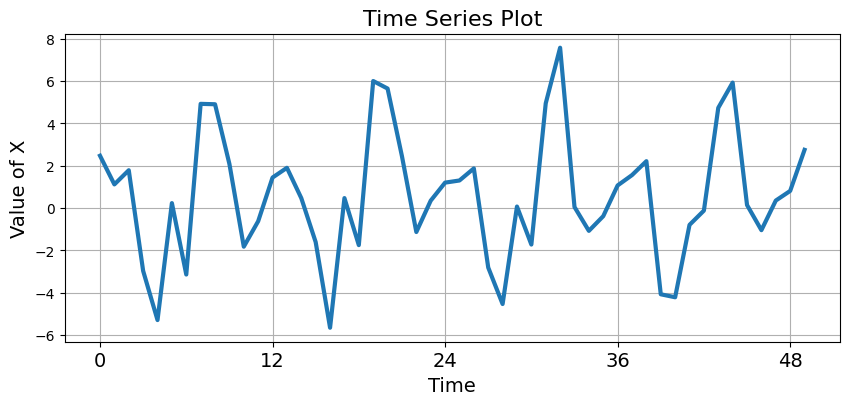

In [4]:

X = generate_samples_101_101_12(phi=0, theta=0, Phi=0.93, Theta=0)
plot_series(X[:50], figsize=(10,4))

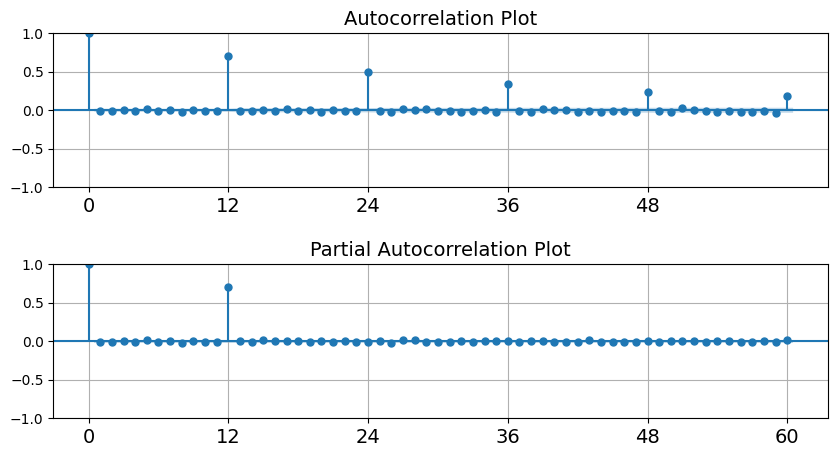

In [5]:
plot_graphs_101_101_12(phi=0, theta=0, Phi=0.7, Theta=0)

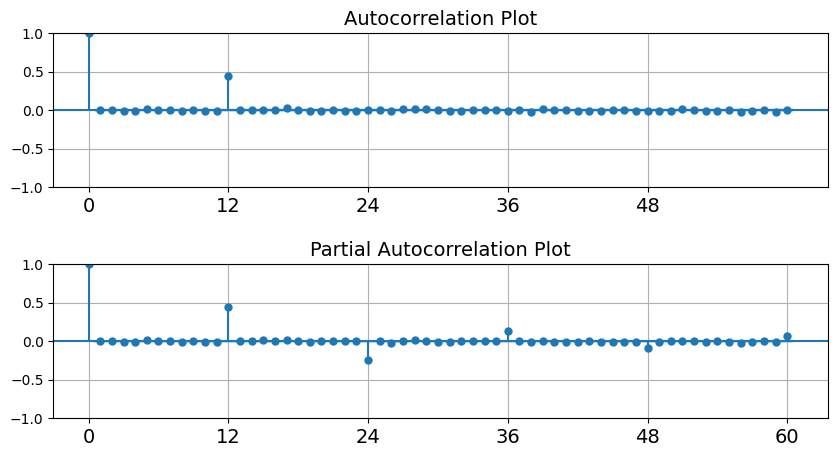

In [6]:
plot_graphs_101_101_12(phi=0, Phi=0, theta=0, Theta=0.6)

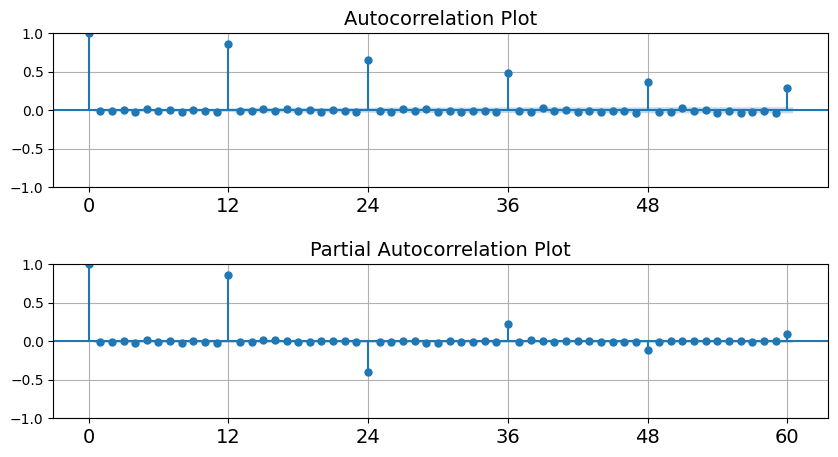

In [7]:

plot_graphs_101_101_12(phi=0, Phi=0.75, theta=0, Theta=0.6)

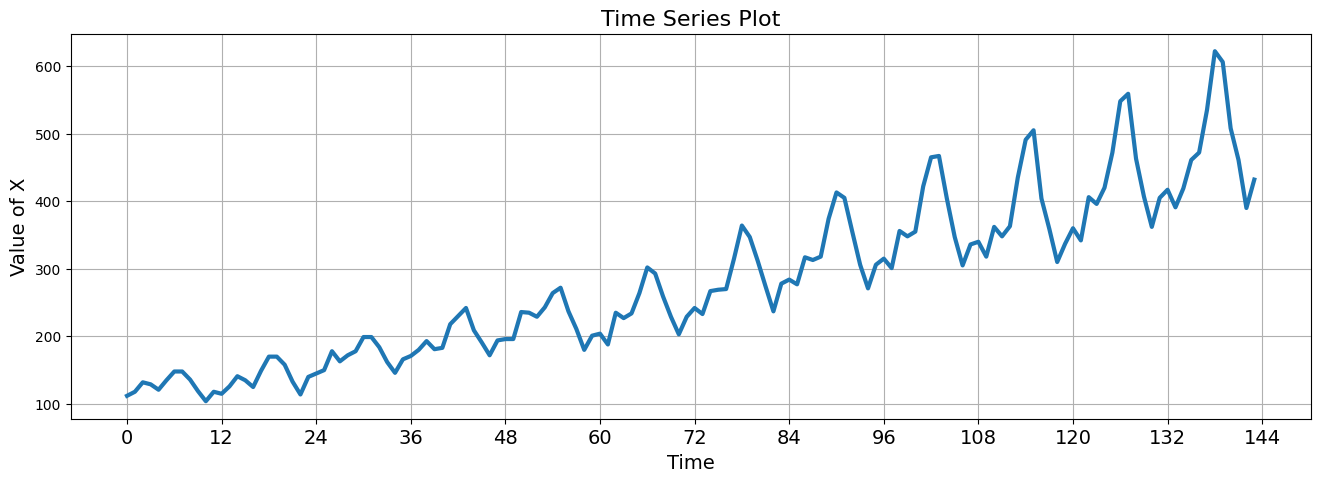

In [8]:
df = pd.read_csv('https://storage.googleapis.com/codehub-data/1-lv2-11-1-AirPassengers.csv')
X = df['#Passengers'].values

plot_series(X, season=12)

In [9]:
season = 12

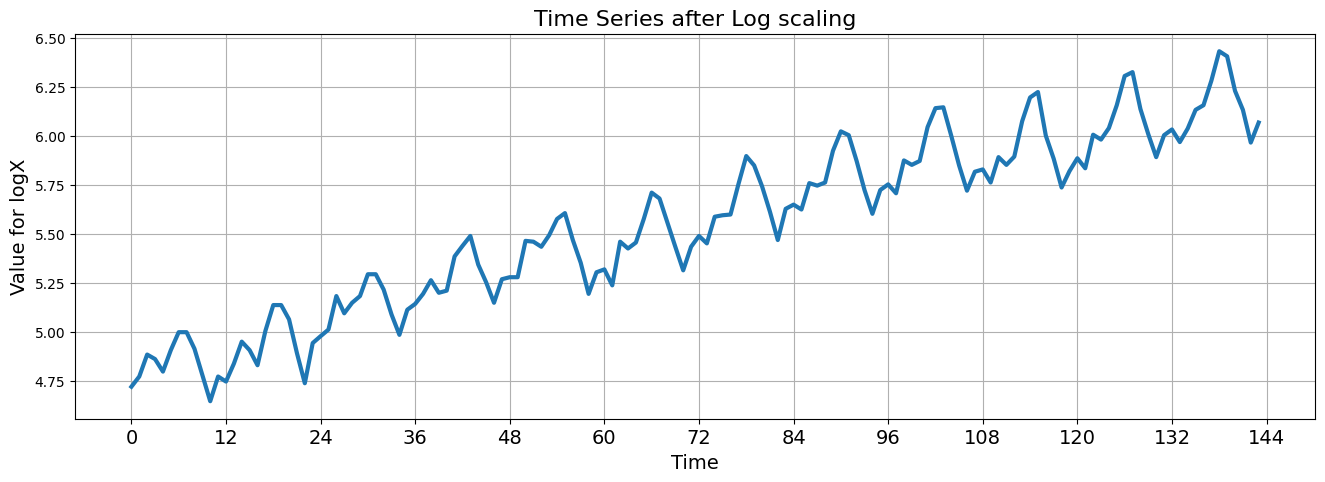

In [10]:
log_X = np.log(X).copy()
plot_series(log_X, title='Time Series after Log scaling', y_label='Value for logX', season=season)

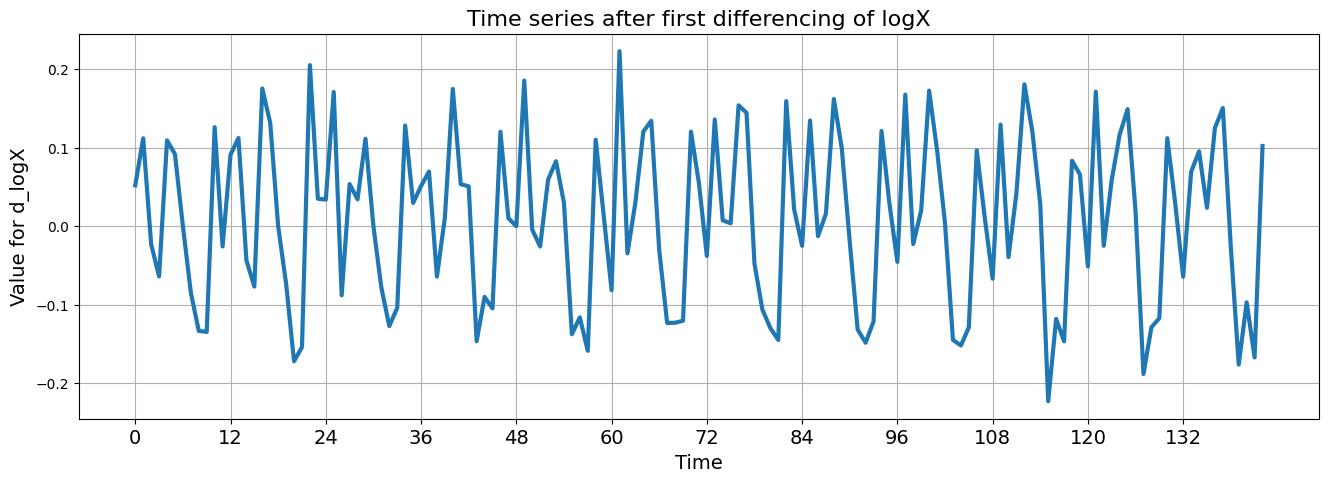

In [11]:
d_log_X = tools.diff(log_X)

plot_series(
    d_log_X, 
    title='Time series after first differencing of logX', 
    y_label='Value for d_logX',
    season=season
)

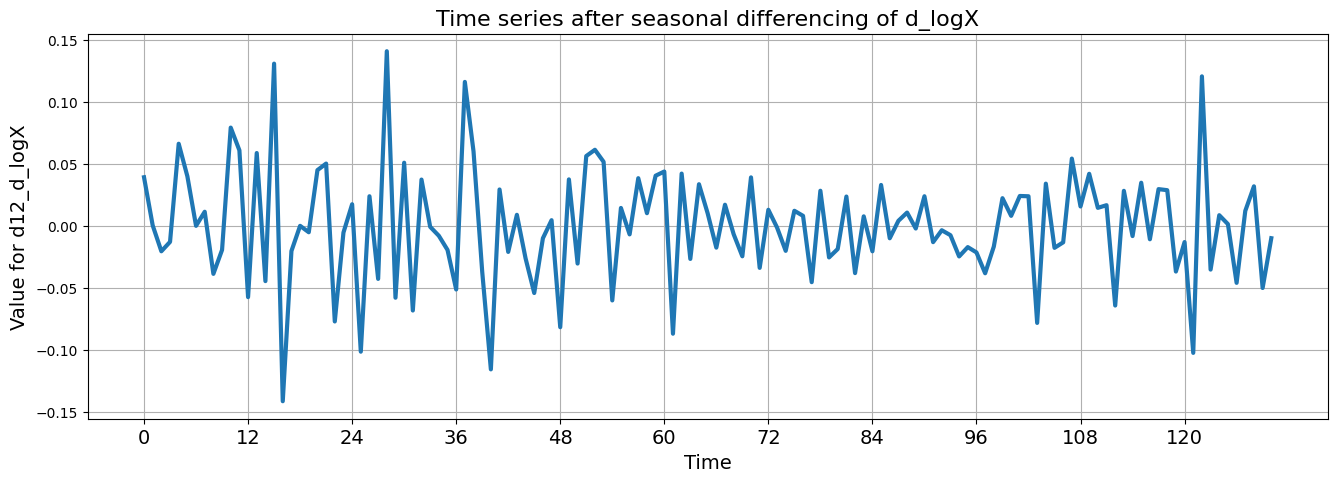

In [12]:
d12_d_log_X = tools.diff(d_log_X, k_diff=0, k_seasonal_diff=1, seasonal_periods=season)

plot_series(
    d12_d_log_X, 
    title = 'Time series after seasonal differencing of d_logX', 
    y_label='Value for d12_d_logX',
    season=season
)

In [13]:
stattools.adfuller(d12_d_log_X)[1] #< 0.05

0.00024859123113839883

In [14]:
d = 1
D = 1
X_stationary = d12_d_log_X

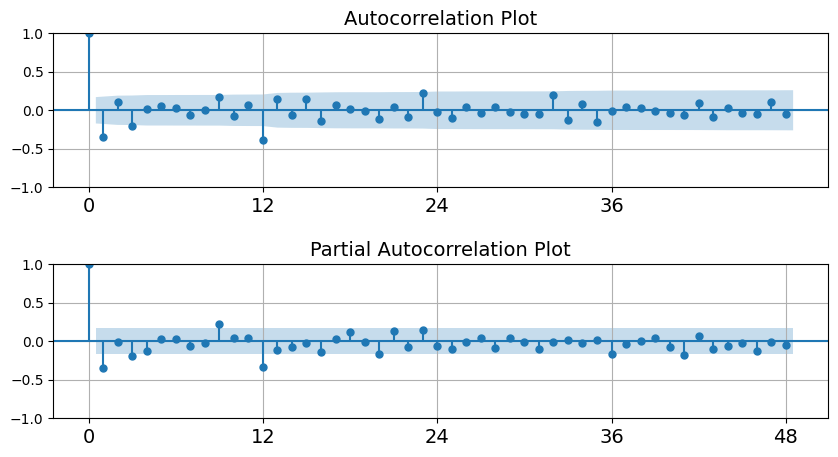

In [15]:
plot_graphs(X_stationary, lags=48, season=season)

In [16]:
# Seasonal orders
P_ = (0, 1)
Q_ = (0, 1)

# Non-seasonal orders
p_ = (0, 3)
q_ = (0, 3)

In [17]:
warnings.simplefilter('error', ConvergenceWarning)

# minimization function
def f(order, X):
    """ Minimization function
        It generates a SARIMA model with provided orders and fits on the time series.
        
    Args:
        order ((int, int, int, int)): Tuple of (p, q, P, Q)
        X (np.array): Time-series data
        
    Returns:
        (float or np.inf): BIC score for the model and np.inf in case of any exception
        
    """
    p, q, P, Q = order
    try:
        model = sm.tsa.SARIMAX(
            X, 
            order=(p, d, q), 
            seasonal_order=(P, D, Q, season)
        )
        model = model.fit(trend='nc', disp=-1)
    except:
        return np.inf
    return model.bic


# brute force search

order_grid = [slice(order[0], order[1] + 1 , 1) for order in (p_, q_, P_, Q_)]

min_order = optimize.brute(f, order_grid, args=(log_X,), finish=None, workers=4)
min_order = min_order.astype(int)

print('Order with minimum BIC : %s'%min_order)

/home/aayush/anaconda3/envs/open_ai/lib/python3.8/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: trend. After release 0.14, this will raise.
  warnings.warn(
/home/aayush/anaconda3/envs/open_ai/lib/python3.8/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: trend. After release 0.14, this will raise.
  warnings.warn(
/home/aayush/anaconda3/envs/open_ai/lib/python3.8/site-packages/statsmodels/base/optimizer.py:18: FutureWarn

Order with minimum BIC : [0 1 0 1]


In [18]:
p, q, P, Q = min_order

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.66903D+00    |proj g|=  5.46246D+00


 This problem is unconstrained.



At iterate    5    f= -1.68810D+00    |proj g|=  1.63838D-01

At iterate   10    f= -1.69357D+00    |proj g|=  2.83790D+00

At iterate   15    f= -1.69921D+00    |proj g|=  7.76305D-03

At iterate   20    f= -1.69925D+00    |proj g|=  1.14449D-01

At iterate   25    f= -1.69928D+00    |proj g|=  2.54228D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     38      1     0     0   4.399D-03  -1.699D+00
  F =  -1.6992811590154655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


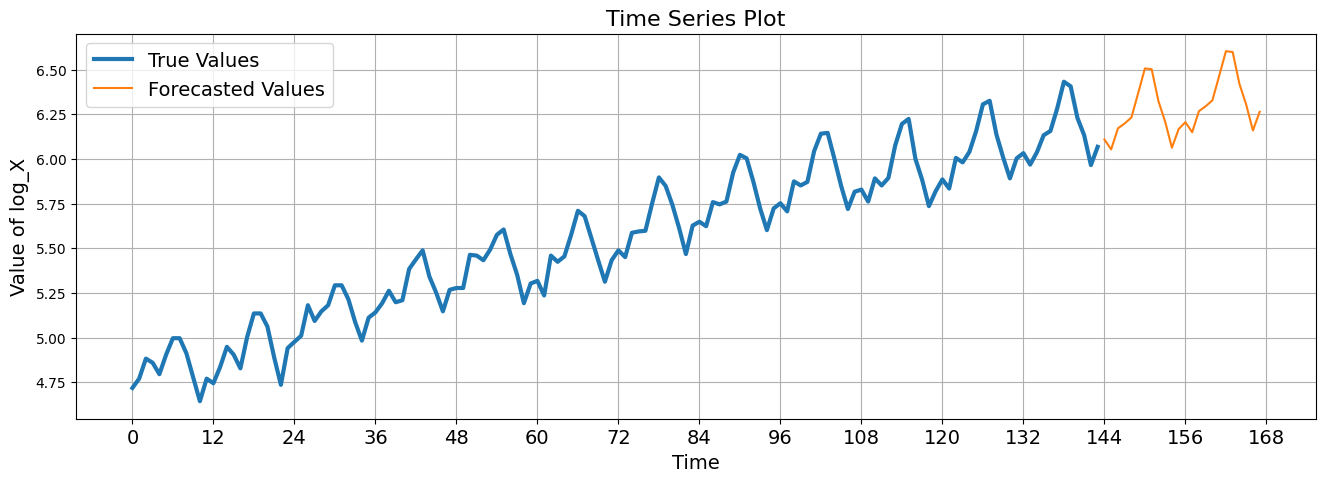

In [21]:
model = sm.tsa.SARIMAX(
    log_X, 
    order=(p, d, q),
    seasonal_order=(P, D, Q, season)
).fit(trend='nc')

X_preds = model.forecast(24)

plot_series(
    log_X, X_preds, 
    y_label='Value of log_X',
    season=season, forecast=True
)

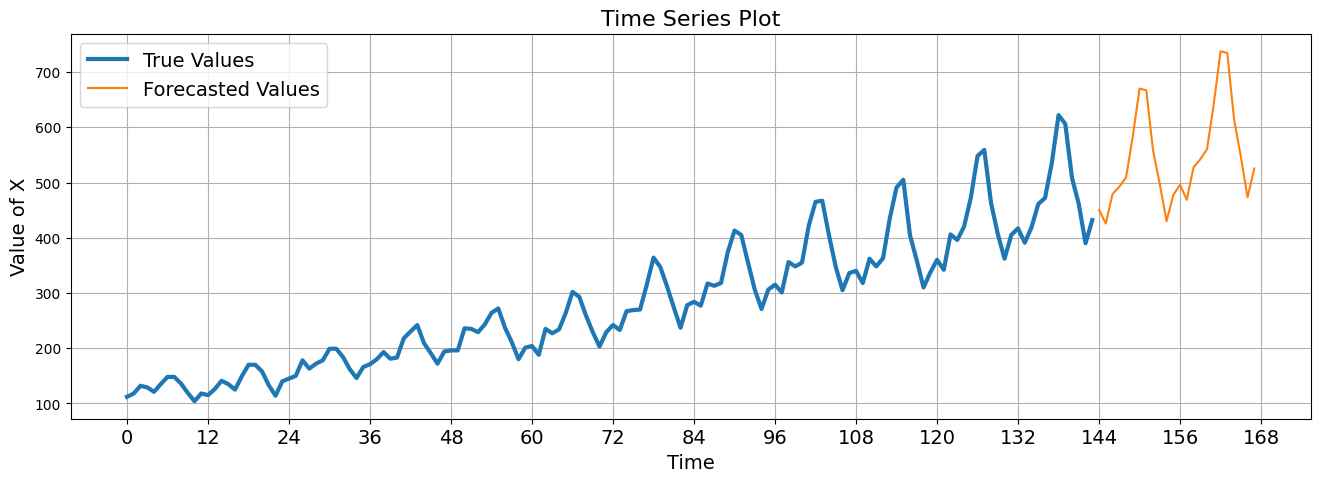

In [22]:
plot_series(
    X, np.exp(X_preds), 
    season=season, forecast=True
)